Continued...

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.interpolate import griddata
from scipy.special import erf
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit

from astropy.coordinates import SkyCoord

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import plots, MCSamples

from loess.loess_2d import loess_2d

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import *

from scipy.stats import norm

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))

# North vs South Consistency Check

## a. $abc$-fixed FP

Rejected comparison: 0
Rejected comparison: 0


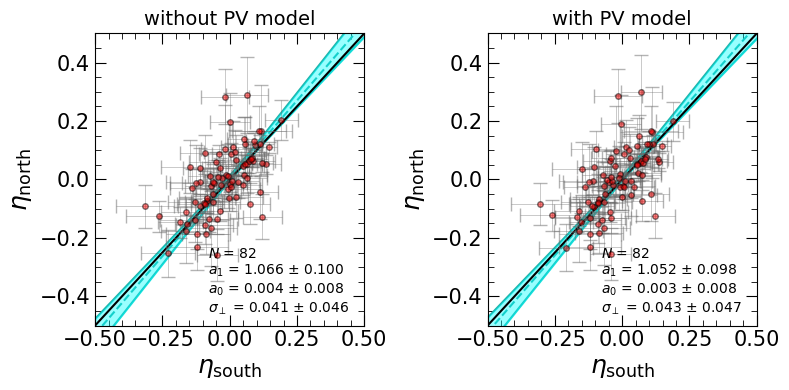

In [17]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
ax_titles = ['without PV model', 'with PV model']

req_cols = ['tmass', 'logdist_abc_fixed', 'logdist_obs_err_abc_fixed']

for i, datapath in enumerate(['../data/foundation/logdist/smin_setting_1/fp_fit_method_0/', '../experiments/experiment_009_logdist_pv_model/']):
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:
        df_temp = pd.read_csv(datapath + survey + '.csv')
        df_temp = df_temp[~df_temp['logdist_obs_err_abc_fixed'].isna()]
        df_north = pd.concat([df_north, df_temp])
    df_north = df_north[req_cols]

    # Read south (6dFGS) data
    df_south = pd.read_csv(datapath + '6dfgs.csv')
    df_south = df_south[~df_south['logdist_obs_err_abc_fixed'].isna()]
    df_south = df_south[req_cols]

    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_abc_fixed_north"] - df[f"logdist_abc_fixed_south"]) / np.sqrt(df[f"logdist_obs_err_abc_fixed_north"]**2 + df[f"logdist_obs_err_abc_fixed_south"]**2)

    df_rejects = df[df["chisq"] > 999]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999]

    ndata = len(df)
    x = df[f"logdist_abc_fixed_south"].to_numpy()
    xerr = df[f"logdist_obs_err_abc_fixed_south"].to_numpy()
    y = df[f"logdist_abc_fixed_north"].to_numpy()
    yerr = df[f"logdist_obs_err_abc_fixed_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_abc_fixed_south"], df_rejects[f"logdist_abc_fixed_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err:.3f}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.42, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
fig.savefig('../img/final_plot/north_vs_south_abc_fixed.pdf', bbox_inches='tight', dpi=300)

## b. Individual FP

Rejected comparison: 0
Rejected comparison: 0


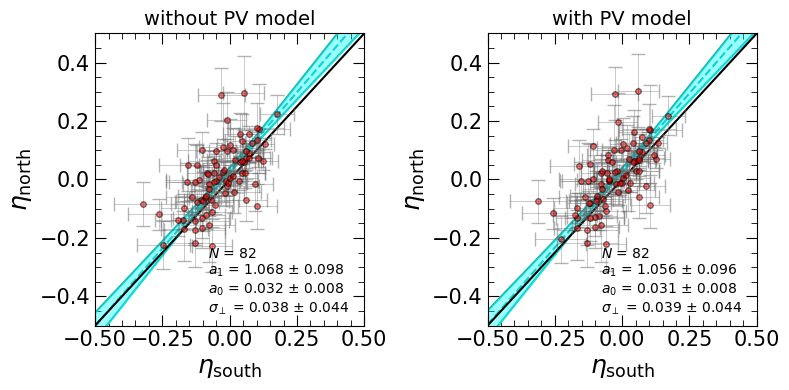

In [18]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
ax_titles = ['without PV model', 'with PV model']

req_cols = ['tmass', 'logdist_individual', 'logdist_obs_err_individual']

for i, datapath in enumerate(['../data/foundation/logdist/smin_setting_1/fp_fit_method_0/', '../experiments/experiment_009_logdist_pv_model/']):
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:
        df_temp = pd.read_csv(datapath + survey + '.csv')
        df_temp = df_temp[~df_temp['logdist_obs_err_individual'].isna()]
        df_north = pd.concat([df_north, df_temp])
    df_north = df_north[req_cols]

    # Read south (6dFGS) data
    df_south = pd.read_csv(datapath + '6dfgs.csv')
    df_south = df_south[~df_south['logdist_obs_err_individual'].isna()]
    df_south = df_south[req_cols]

    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_individual_north"] - df[f"logdist_individual_south"]) / np.sqrt(df[f"logdist_obs_err_individual_north"]**2 + df[f"logdist_obs_err_individual_south"]**2)

    df_rejects = df[df["chisq"] > 999]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999]

    ndata = len(df)
    x = df[f"logdist_individual_south"].to_numpy()
    xerr = df[f"logdist_obs_err_individual_south"].to_numpy()
    y = df[f"logdist_individual_north"].to_numpy()
    yerr = df[f"logdist_obs_err_individual_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_individual_south"], df_rejects[f"logdist_individual_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.42, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
fig.savefig('../img/final_plot/north_vs_south_individual.pdf', bbox_inches='tight', dpi=300)

# Cross-survey consistency check

## a. $abc$-fixed FP

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 0
Rejected comparison in ('6dFGS', 'LAMOST'): 0


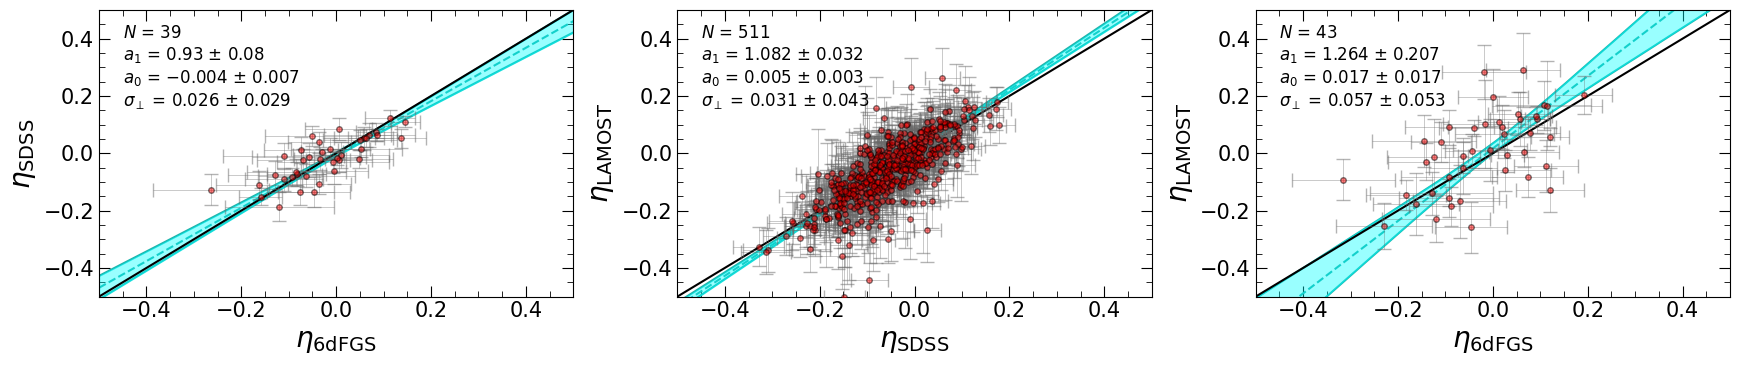

In [19]:
method = "abc_fixed"
SIGMA_CLIP = 3.0

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_abc_fixed_fp.pdf', bbox_inches='tight', dpi=300)

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 0
Rejected comparison in ('6dFGS', 'LAMOST'): 0


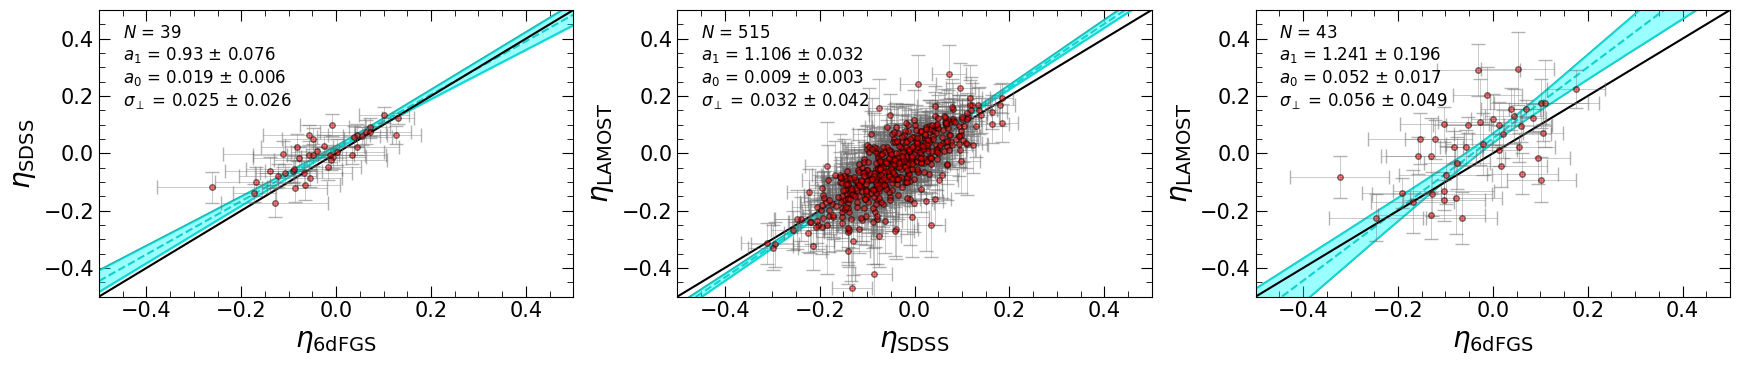

In [20]:
method = "individual"
SIGMA_CLIP = 3.0

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
fig.savefig('../img/final_plot/fig_11b_internal_consistency_checks_individual_fp.pdf', bbox_inches='tight', dpi=300)

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 2
Rejected comparison in ('6dFGS', 'LAMOST'): 0


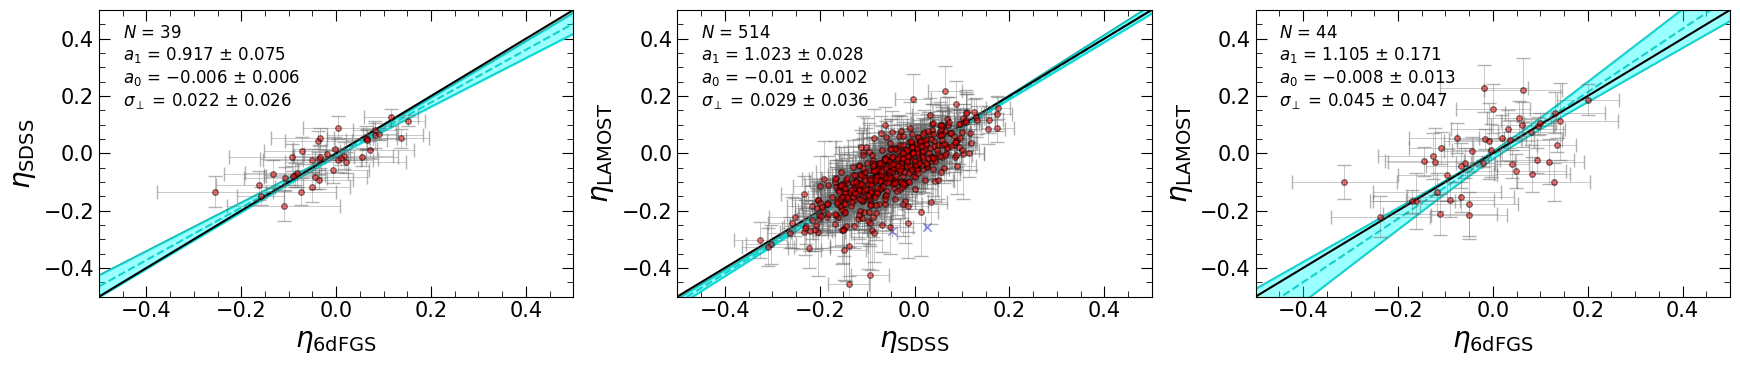

In [13]:
method = "combined"
SIGMA_CLIP = 2.5

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
# fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_combined_fp.pdf', bbox_inches='tight', dpi=300)

# Logdist Trends

Std of logdist:  0.1109325529405107
Std of absMag:  0.6893573909714232
Coefficient of correlation:  -0.8046084251319017
Predicted slope:  -0.1294789435586478


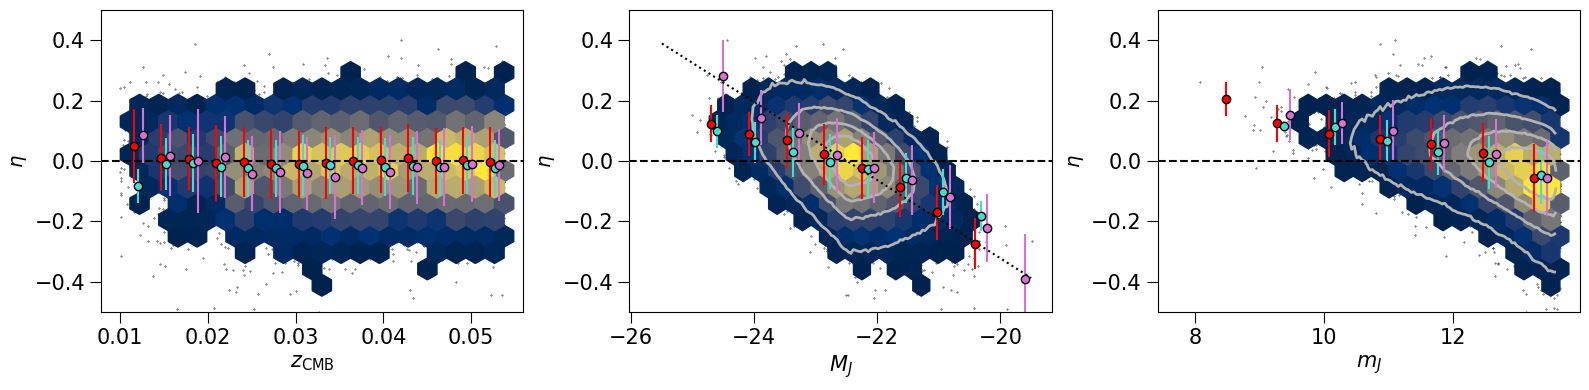

In [15]:
survey_list = ["6dFGS", "SDSS", "LAMOST"]
fig, axs = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))

# Load logdist-derived mocks
df_mock = pd.read_csv("../experiments/experiment_010_mock_logdist/mocks_all_combined.csv")
df_mock["mag_j"] -= df_mock["extinction_j"]

# Plot mock contour for absolute magnitude
mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.7)), (0.5, (0.04, 0.04), mock_cmap(0.7)), (0.75, (0.04, 0.04), mock_cmap(0.7)), (0.95, (0.04, 0.04), mock_cmap(0.7))]
density_contour(df_mock['absmag_j'].to_numpy(), df_mock['logdist'].to_numpy(), bins_levels_tuple_list=levels_plot_mock, ax=fig.axes[1], linewidths=2.0, linestyles="-")

# Plot mock contour for apparent magnitude
mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.7)), (0.5, (0.04, 0.04), mock_cmap(0.7)), (0.75, (0.04, 0.04), mock_cmap(0.7)), (0.95, (0.04, 0.04), mock_cmap(0.7))]
density_contour(df_mock['mag_j'].to_numpy(), df_mock['logdist'].to_numpy(), bins_levels_tuple_list=levels_plot_mock, ax=fig.axes[2], linewidths=2.0, linestyles="-")

# Parameters for each plot
x_params = ["z_dist_est", "absMag_j", "mag_j"]
x_params_labels = [r"$z_\mathrm{CMB}$", r"$M_J$", r"$m_J$"]
n_data = [15, 10, 8]
offsets = [0.0005, 0.1, 0.1]
survey_colors = ["r", "turquoise", "orchid"]
survey_shapes = ["o", "o", "o"]

# Combine surveys
df_combined = pd.DataFrame()
for survey in survey_list:
    df_temp = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_temp["survey"] = survey
    df_temp["mag_j"] = df_temp["j_m_ext"] - df_temp["extinction_j"]
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

# Calculate J-band absolute magnitude
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
d_C = sp.interpolate.splev(df_combined["z_dist_est"].to_numpy(), dist_spline)
d_L = (1 + df_combined["zhelio"]) * d_C * 10**6
df_combined["absMag_j"] = (df_combined["j_m_ext"] - df_combined["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df_combined["kcor_j"]

sigma_eta = np.std(df_combined["logdist_abc_fixed"])
sigma_M = np.std(df_combined["absMag_j"])
print("Std of logdist: ", sigma_eta)
print("Std of absMag: ", sigma_M)
print("Coefficient of correlation: ", -5 * sigma_eta / sigma_M)
print("Predicted slope: ", -5 * sigma_eta**2 / sigma_M**2)

# Merge with John's GALFIT measurements to get sersic index
df_galfit = pd.read_csv("../data/raw/r_e_jrl/combined/jhk_r_e.csv")[["tmass", "galfit_ser_j"]]
df_combined = df_combined.merge(df_galfit, on="tmass", how="left")

# Separate the dataframe again
dfs = []
for survey in survey_list:
    dfs.append(df_combined[df_combined["survey"] == survey])


for i, ax in enumerate(fig.axes):
    # Parameter to plot
    x_param = x_params[i]

    ax.scatter(df_combined[x_param], df_combined['logdist_abc_fixed'], s=0.1, c='k')
    h = ax.hexbin(df_combined[x_param], df_combined['logdist_abc_fixed'], gridsize=(20, 10), mincnt=5, cmap="cividis")

    for j, survey in enumerate(survey_list):
        offset = j * offsets[i]

        df_ = dfs[j]
        
        x = df_[x_param].to_numpy()
        y = df_["logdist_abc_fixed"].to_numpy()
        yerr = df_["logdist_err_abc_fixed"].to_numpy()

        x_full = df_combined[x_param].to_numpy()
        x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data(x=x, y=y, yerr=yerr, xmin=x_full.min(), xmax=x_full.max(), n_bin=n_data[i])

        ax.errorbar(x_bin + offset, y_bin, yerr=y_bin_err, fmt=survey_shapes[j], mec='k', mfc=survey_colors[j], ecolor=survey_colors[j], alpha=1.0)
    
    ax.axhline(y=0, c='k', ls='--')

    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(x_params_labels[i], fontsize=15)
    ax.set_ylabel(r"$\eta$", fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=15, direction="out")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

# Predicted slope for middle panel
m = -5 * sigma_eta**2 / sigma_M**2
x0 = np.median(df_combined["absMag_j"])
x_trial = np.linspace(-25.5, -19.5, 50)
y_trial = m * (x_trial - x0)
ax = fig.axes[1]
ax.plot(x_trial, y_trial, c='k', ls=':')
 
fig.tight_layout()
fig.savefig('../img/final_plot/fig_12_logdist_trend.pdf', bbox_inches='tight', dpi=300)

# PV bias vs redshift

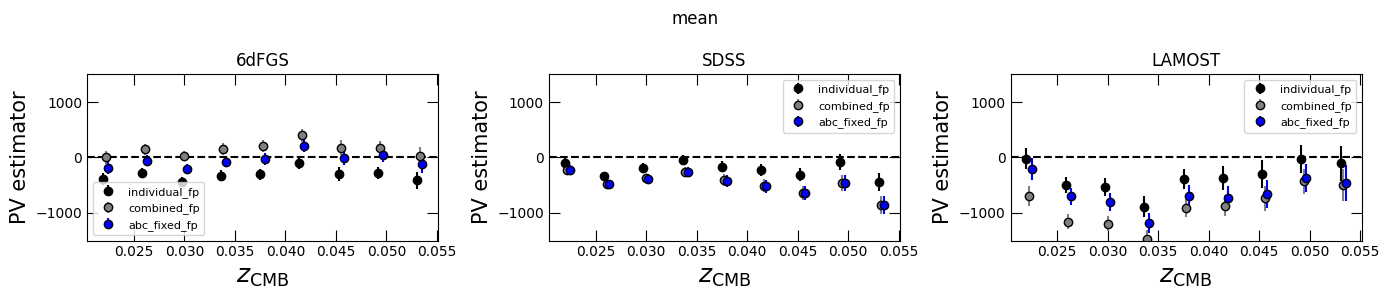

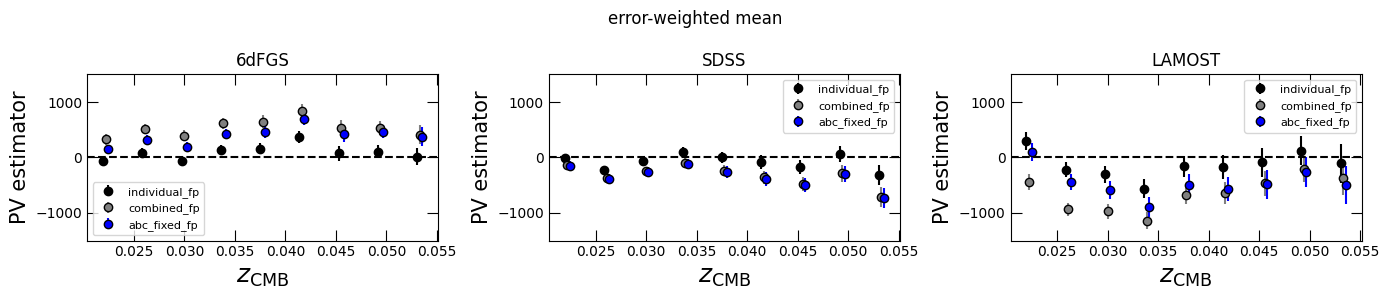

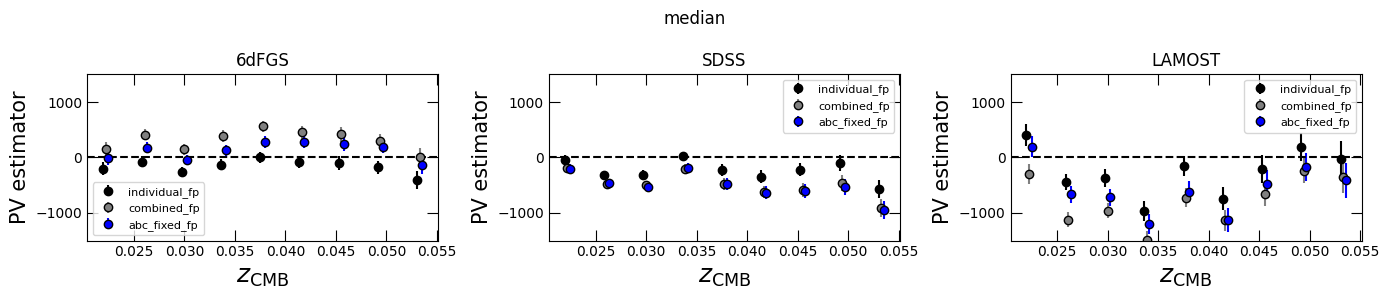

In [16]:
# Functions to average the data
avg_functions = [bin_data, bin_data_error_weighting, bin_data_median]
avg_func_labels = ["mean", "error-weighted mean", "median"]

for i, func in enumerate(avg_functions):
    fig, axs = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(avg_func_labels[i])

    for j, survey in enumerate(SURVEY_LIST):
        ax = fig.axes[j]

        # Load old data
        df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
        df["logdist_individual_fp"] = df[f"logdist_individual"]
        df["logdist_err_individual_fp"] = df[f"logdist_err_individual"]

        df["logdist_combined_fp"] = df["logdist_combined"]
        df["logdist_err_combined_fp"] = df["logdist_err_combined"]

        df["logdist_abc_fixed_fp"] = df["logdist_abc_fixed"]
        df["logdist_err_abc_fixed_fp"] = df["logdist_err_abc_fixed"]

        epsilon = 0.75
        z_col = "z_dist_est"

        colors = ["black", "grey", "blue", "red", "green"]

        for k, method in enumerate(["individual_fp", "combined_fp", "abc_fixed_fp"]):
            df["pv"] = LIGHTSPEED * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
            df["pv_err"] = LIGHTSPEED * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

            # Get error-weighted average in bins
            x = df[z_col].to_numpy()
            y = df[f"pv"].to_numpy()
            yerr = df[f"pv_err"].to_numpy()

            # Bin the data in redshift
            x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = func(x, y, yerr, 0.02, 0.055, 10)

            # Plot
            ax.errorbar(x_bin + k * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[k], ecolor=colors[k], alpha=1.0, label=method)

        ax.set_title(survey)
        ax.axhline(y=0, c='k', ls='--')
        ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
        ax.set_ylabel("PV estimator", fontsize=15)

        ax.set_ylim(-1500, 1500)
        ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
        ax.tick_params(axis='both', which='both', labelsize=10, direction="in")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

        if j == 0:
            ax.legend(loc="lower left", fontsize=8)
        else:
            ax.legend(loc="upper right", fontsize=8)

    fig.tight_layout()
    # fig.savefig(f"./pv_bias_{avg_func_labels[i]}.png", bbox_inches='tight', dpi=300)

# Logdist vs richness

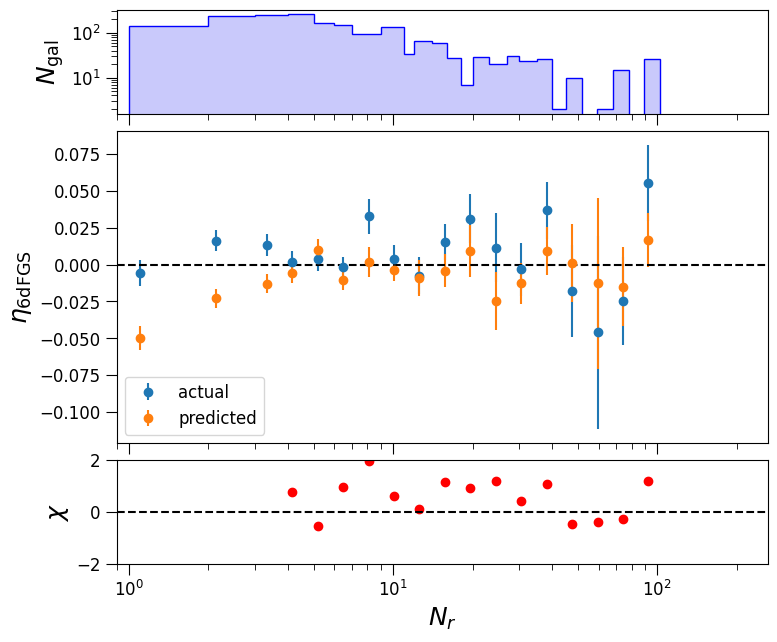

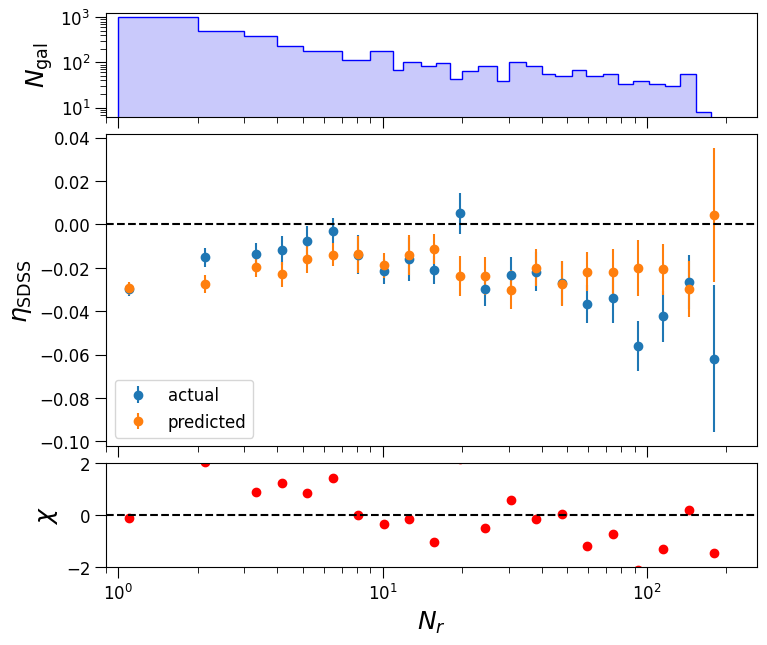

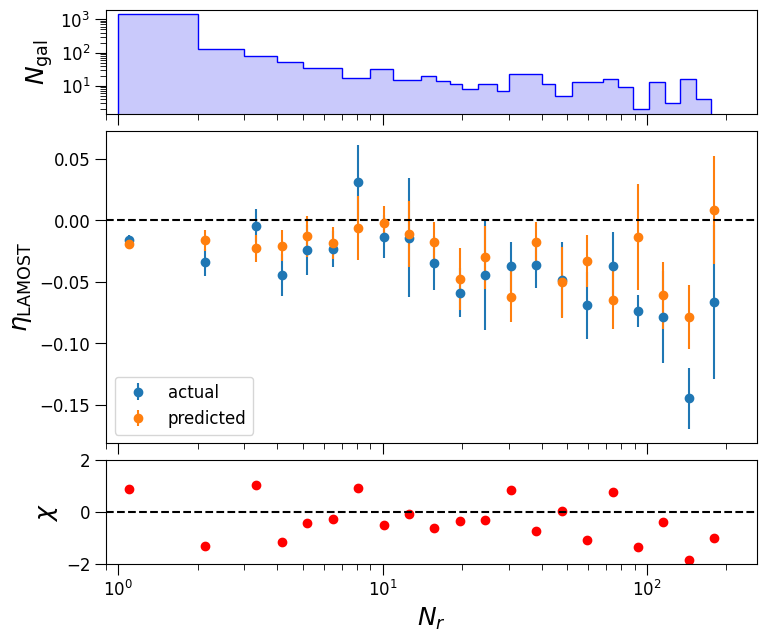

In [50]:
# Linear function
def linear_func(x, m, c):
    return m * x + c

for survey in SURVEY_LIST:
    # Load log-distance ratio
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv')

    # Calculate J-band absolute magnitude
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    d_C = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    d_L = (1 + df["zhelio"]) * d_C * 10**6
    df["absMag_j"] = (df["j_m_ext"] - df["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df["kcor_j"]

    # Calculate absolute magnitude rolling mean
    x_param = "absMag_j"
    window_size = 0.1
    x_pts = np.linspace(df[x_param].min(), df[x_param].max(), 25)

    x = df["absMag_j"].to_numpy()
    y = df["logdist_abc_fixed"].to_numpy()
    yerr = df["logdist_err_abc_fixed"].to_numpy()

    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, x.min(), x.max(), 15)

    # Fit linear relationship
    popt, pcov = curve_fit(linear_func, x_bin, y_bin, p0=[-0.1, -10])

    x_ = np.linspace(x.min(), x.max(), 100)
    y_ = linear_func(x_, popt[0], popt[1])

    # Richness bins
    richness_bins = np.logspace(-0.01, np.log10(200), 25)
    richness_bins_labels = range(1, len(richness_bins))

    # Median richness in each bin
    df['richness_bin'] = pd.cut(df['Nr'], richness_bins, labels=richness_bins_labels)
    absmag_binned_median = df[['richness_bin', "absMag_j"]].groupby(by='richness_bin', observed=False).median().values.ravel()

    # Predicttion from linear relation
    logdist_pred = linear_func(absmag_binned_median, popt[0], popt[1])
    logdist_pred_err = 0.08

    # Predict log-distance ratio from the trend
    df['logdist_pred'] = linear_func(df['absMag_j'].to_numpy(), *popt)

    # Richness bins
    richness_bins = np.logspace(-0.01, np.log10(200), 25)
    richness_bins_labels = range(1, len(richness_bins))

    scale = 1.2
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(7 * scale, 6 * scale), height_ratios=[1, 3, 1], sharex=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)

    # Histogram of group richness
    histogram_bins = np.unique(np.ceil(np.logspace(0., np.log10(200), 40)))
    ax1.hist(df["Nr"], bins=histogram_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
    ax1.set_yscale("log")
    ax1.set_ylabel("$N_\mathrm{gal}$", fontsize=18)

    # Trend of logdist vs richness
    df['richness_bin'] = pd.cut(df['Nr'], richness_bins, labels=richness_bins_labels)
    richness_bins_middle = 0.5 * (richness_bins[1:] + richness_bins[:-1])
    logdist_binned_mean = df[['richness_bin', "logdist_abc_fixed"]].groupby(by='richness_bin', observed=False).median().values.ravel()
    logdist_binned_std = df[['richness_bin', "logdist_abc_fixed"]].groupby(by='richness_bin', observed=False).std().to_numpy().ravel()
    logdist_binned_stderr = df[['richness_bin', "logdist_abc_fixed"]].groupby(by='richness_bin', observed=False).std().to_numpy().ravel() / np.sqrt(df[['richness_bin', "logdist_abc_fixed"]].groupby(by='richness_bin', observed=False).count().to_numpy().ravel())

    # Predicted logdist from logdist vs absolute magnitude relation
    err_absmag_relation = 0.08
    logdist_pred_binned_mean = df[['richness_bin', "logdist_pred"]].groupby(by='richness_bin', observed=False).median().values.ravel()
    logdist_pred_binned_stderr = np.sqrt(df[['richness_bin', "logdist_pred"]].groupby(by='richness_bin', observed=False).std().to_numpy().ravel()**2 + err_absmag_relation**2) / np.sqrt(df[['richness_bin', "logdist_pred"]].groupby(by='richness_bin', observed=False).count().to_numpy().ravel())

    ax2.errorbar(richness_bins_middle, logdist_binned_mean, yerr=logdist_binned_stderr, fmt='o', label='actual')
    ax2.errorbar(richness_bins_middle, logdist_pred_binned_mean, yerr=logdist_pred_binned_stderr, fmt='o', label='predicted')

    ax2.legend(loc="lower left", fontsize=12)
    ax2.axhline(y=0, c='k', ls='--')
    ax2.set_ylabel(r"$\eta_\mathrm{survey}$".replace("survey", survey), fontsize=18)

    # Calculate statistical significance
    chisq = (logdist_binned_mean - logdist_pred_binned_mean) / np.sqrt(logdist_binned_stderr**2 + logdist_pred_binned_stderr**2)
    ax3.scatter(richness_bins_middle, chisq, c='r', marker='o')
    ax3.axhline(y=0, c='k', ls='--')

    ax3.set_ylabel(r"$\chi$", fontsize=18)
    ax3.set_xlabel(r"$N_r$", fontsize=18)
    ax3.set_xscale("log")
    ax3.set_xlim(left=0.9)
    ax3.set_ylim(-2, 2)

    for ax in fig.axes:
        ax.tick_params(axis='both', which='both', labelsize=12, direction="out")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

    # fig.savefig(f'../img/final_plot/{survey.lower()}_richness.pdf', bbox_inches='tight', dpi=300)